In [451]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from scipy.signal import convolve2d
from scipy.signal import convolve
import copy
import json
import time as tm

In [452]:
"""
Changeable parameters
"""
filepath = 'cosmo_test_100225_'

n_strains = 2
n_nutrients = 2

#The dependencies of strain the strains on each nutrient. Within each strain and nutrient, COLUMN 1 is UPTAKE, 
#COLUMN 2 is RELEASE. 1 means they do that function, 0 means they do not
dependencies = np.zeros((n_strains,n_nutrients,2))


#This initialization is for classic CoSMO type crossfeeding.
dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,0,1] = 1 #strain 2, release nutrient 1

#include this for cheater strain 3
#dependencies[2,1,0] = 1 #strain 3, uptake nutrient 2

#include this for cheater strain 3
#dependencies[2,2,0] = 1 #strain 2, uptake nutrient 2


"""
circle for n=3

dependencies[0,0,0] = 1 #strain 1, uptake nutrient 1
dependencies[0,1,1] = 1 #strain 1, release nutrient 2

dependencies[1,1,0] = 1 #strain 2, uptake nutrient 2
dependencies[1,2,1] = 1 #strain 2, release nutrient 3

dependencies[2,2,0] = 1 #strain 3, uptake nutrient 3
dependencies[2,0,1] = 1 #strain 2, release nutrient 1
"""


'\ncircle for n=3\n\ndependencies[0,0,0] = 1 #strain 1, uptake nutrient 1\ndependencies[0,1,1] = 1 #strain 1, release nutrient 2\n\ndependencies[1,1,0] = 1 #strain 2, uptake nutrient 2\ndependencies[1,2,1] = 1 #strain 2, release nutrient 3\n\ndependencies[2,2,0] = 1 #strain 3, uptake nutrient 3\ndependencies[2,0,1] = 1 #strain 2, release nutrient 1\n'

In [469]:
"""
general variables for diffusion
"""

side_len = 750 #microns
box_height = 1000 #microns
cell_size = 5 #microns
cell_to_diff_ratio = 2
density = 1 #mm^-2

t_final = 24 #hrs
dt = 0.1 #hrs

nsteps = int(t_final/dt)
time = np.arange(nsteps)/dt + dt

D = 360 #um^2/s
DS = np.zeros(n_nutrients)
DS[:] = D/np.square(cell_size*cell_to_diff_ratio) #cell_side^2/s
print(DS)

[3.6 3.6]


In [470]:
"""
calculated quantities
"""
#the box to keep cells in
cell_sides = int(side_len/cell_size)
cell_height = int(box_height/cell_size)
X = np.zeros((cell_sides,cell_sides,cell_sides))

#the boxes for each nutrient
diff_sides = int(cell_sides/cell_to_diff_ratio)
diff_height = int(cell_height/cell_to_diff_ratio)

#The blank matrix into which nutrients will go
S = np.zeros((n_nutrients,diff_sides,diff_sides,diff_sides))
indicies = np.arange(diff_sides)

#lets make a distances array so that we don't have to calculate it each time
side = np.arange(diff_sides)*cell_size*cell_to_diff_ratio
#print(np.shape(side))
SQ = np.add.outer(np.square(side),np.square(side))
#print(np.shape(SQ))
QB = np.add.outer(SQ,np.square(side))
#print(np.shape(QB))
dists = np.sqrt(QB)

epsilon = 1
dists[0,0,0] = epsilon

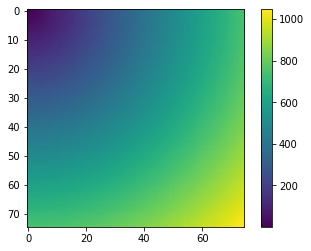

In [471]:
plt.imshow(dists[0,:,:])
plt.colorbar()
plt.show()

(75, 75, 75)


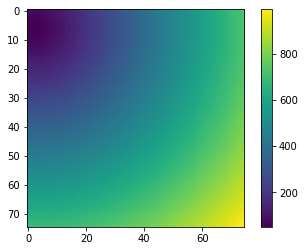

In [472]:
indicies = np.arange(diff_sides)
shifted = np.zeros(np.shape(S[0,...]))

my_point = (5,6,2)

xes = np.abs(indicies-my_point[0])
yes = np.abs(indicies-my_point[1])
zes = np.abs(indicies-my_point[2])

shifted = dists[xes[:,None,None],
                yes[None,:,None],
                zes[None,None,:]]
print(np.shape(shifted))

plt.imshow(shifted[0,:,:])
plt.colorbar()
plt.show()


In [473]:
"""
nutrient initialization 
"""
#We are going to do something a little wild here. Because all of our CoSMO strains have the same genetic background
#outside of the specific mutations, we are going to assume that the effect of growth of the various nutrients on
#different strains is the same. That is, we can define how a nutrient affects cell growth and apply those same 
#rates to every other cell that depends on that nutrient. In this manner, we can write out all of the rates
#for each nutrient once and then simply apply those constraints to a cell's growth by defining its dependencies. 
#This will further allow us to flexibly modulate the various interdependencies of different cell types.

#Lys
alphaL = 5.4 #nutrient required for reproduction (fmole)
rL = 0.51 #Maximum growth rate (hr^-1)
vmL = alphaL*rL #maximum uptake rate (fmole/hr)
"""
060125 The dt for diffusion is 1 second, so to ease calculations, we will put all of the parameters that are 
updated at the same time as diffusion in terms of seconds.
"""
vmL_s = vmL/(60^2) #maximum uptake rate (fmole/s)
KL = 8.1e5*(0.005**3) #Monod constant (fmole/ml)
print(KL)
gammaL = 0.4 #release rate (fmole/(cell*hr))
gammaL_s = gammaL/(60^2) #release rate (fmole/(cell*s))
dL = 0.021 #death rate (hr^-1)

#Ade
alphaA = 3.1
rA = 0.44
vmA = alphaA*rA
vmA_s = vmA/(60^2)
KA = 5.3e5*(0.005**3)
gammaA = 0.26
gammaA_s = gammaA/(60^2)
dA = 0.015 #death rate (hr^-1). Should this be an order of magnitude higher?


alphas = [alphaL,alphaA]
betas = [0.001,0.001]
vm_list = [vmL,vmA]
gamma_list = [gammaL,gammaA]
km_list = [KL,KA]
d = [dL,dA]
r_list = [rL,rA]

0.10125000000000002


In [474]:
class Cell:
    """Hold the properties and variables for strains."""
    def __init__(self,
                 x: int,
                 y: int,
                 z: int,
                 dependencies: np.ndarray,
                 d: float,
                 typ: int,
                 cell_to_diff_ratio: float
                ):
        
        self.x = x
        self.y = y
        self.z = z
        
        #location in the nutrient grid
        self.i = int(x // cell_to_diff_ratio)
        self.j = int(y // cell_to_diff_ratio)
        self.k = int(z // cell_to_diff_ratio)
        
        self.dependencies = dependencies
        self.life_flag = True
        self.quiescence_flag = False
        self.death_rate = d
        self.alphas = alphas
        self.typ = typ
        
    
    def create_daughter(self, x, y, z):
        """
        Create a daughter cell at the specified position
        Should return a new Cell instance with:
        - Same dependencies and parameters as parent
        - New position (x, y, z)
        - Zero internal nutrients
        """
        daughter = Cell(x,y,z,
                        self.dependencies,
                        self.death_rate,
                        self.typ,
                        cell_to_diff_ratio
                       )
        return daughter

In [475]:
def iterate_life_and_death(cells,dt,alphas,km_list,r_list,n_nutrients,S,X):
    
    X_upd = np.zeros(np.shape(X))
    new_cells = []
    
    #to do 100225: randomly loop through these
    #loop over each cell and enumerate it's parameters
    for idx, cell in enumerate(cells):
        
        cell = cells[idx]
        typ = cell.typ
        
        if cell.quiescence_flag or not cell.life_flag:
            continue

        #try to kill it
        rnd = np.random.rand()
        prob_death = cell.death_rate*dt
        if rnd<prob_death:
            #print('Death')
            cell.life_flag = False
            continue


        #assess the requirements for budding
        budded = False
        n_requirements = 0
        which_dependency = np.zeros(n_nutrients)
        for nn in range(n_nutrients):

            if cell.dependencies[nn,0]==1: 
                which_dependency[n_requirements] = int(nn)
                n_requirements += 1
                
        #decide if budding occurred
        if n_requirements==0:

            rnd = np.random.rand()
            prob_division = r_list[int(typ-1)]*dt
            #print('probability of division = %s' %prob_division)
            
            if rnd<prob_division:
                #print('Division conditions met!')
                budded = True


        else: 
            
            probabilities = np.zeros(int(n_requirements))
            
            for rr in range(int(n_requirements)):
                
                S_loc = S[int(which_dependency[rr]),cell.i,cell.j,cell.k]
                probabilities[rr] = r_list[int(which_dependency[rr])]*S_loc/(S_loc + km_list[int(which_dependency[rr])])
                
                #print('repr_rate = %s'%(r_list[int(which_dependency[rr])]*S_loc/(S_loc + km_list[int(which_dependency[rr])])))
                
            rnd = np.random.rand()
            prob_division = np.prod(probabilities)*dt
            #print('probability of division = %s' %prob_division)
            
            if rnd<prob_division:
                budded = True



        """
        Now that we have decided if something has budded let us determine where the bud goes
        """
        if budded:
            bud_coords = get_bud_location(cell,X)
            if bud_coords is not None:              
                daughter = cell.create_daughter(bud_coords[0],bud_coords[1],bud_coords[2])
                cell.S_internal = np.zeros(n_nutrients)
                new_cells.append(daughter)
                
                #print(bud_coords)
                #print(cell.typ)
                
                X_upd[bud_coords[0],bud_coords[1],bud_coords[2]] = cell.typ
                                
                                
    return new_cells, X_upd

In [476]:
def periodic_image(coord,dimension):
    return int(coord%dimension)

In [477]:
def get_bud_location(cell,X_og):
    
    """
    The general strategy will be to generate a list of adjacent points with respect to periodic boundary 
    conditions. Then, make a smaller list of these points that are empty. If there are no empty points in the 
    plane, we will search the plane above. Once a list of potential points has been generated, the cell will 
    randomly bud into one. 
    """
    X = X_og.copy()
    
    #the coordinates of the cell to be propagated
    coords = np.array([cell.x,cell.y,cell.z])
    
    shp = np.shape(X)
    
    
    #make a 3x3 stencil to search with
    xes = np.zeros(9)
    yes = np.zeros(9)

    xes[:3] = periodic_image(coords[0] - 1,shp[0])
    xes[3:6] = periodic_image(coords[0],shp[0])
    xes[6:] = periodic_image(coords[0] + 1,shp[0])

    yes[0::3] = periodic_image(coords[1] - 1,shp[1])
    yes[1::3] = periodic_image(coords[1],shp[1])
    yes[2::3] = periodic_image(coords[1] + 1,shp[1])
    
    
    poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2])]==0]
    
    n_possibilities = np.size(poss_xvals)
    floor = 0
    
    success = True

    
    if n_possibilities == 0:
        #print('trying one floor up')
        
        new_poss_xvals = xes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]
        new_poss_yvals = yes[X[xes.astype('int'),yes.astype('int'),int(coords[2] + 1)]==0]

        n_new_possibilities = np.size(new_poss_xvals)
        
        if n_new_possibilities == 0:
            #print('no available space, cannot bud')
            cell.quiescence_flag = True
            success = False
        else:
            poss_xvals = new_poss_xvals
            poss_yvals = new_poss_yvals
            n_possibilities = n_new_possibilities
            floor = 1
            
    if success:
        #print('Budding!')
        index_to_bud = int(np.floor(np.random.rand()*n_possibilities))
        bud_coords = [int(poss_xvals[index_to_bud]),int(poss_yvals[index_to_bud]),int(coords[2]+floor)]
        
        return bud_coords
    
    else: 
        return None

In [478]:
def update_nutrients(S,DS,diff_sides,distances,n_nutrients,cells,X,dt_diff,alphas,betas,gamma_list):
    
    #To begin, let us assume that we re-calculate the steady state nutrient every time. 
    #S = np.zeros((n_nutrients,diff_sides,diff_sides,diff_sides))
    
    for nn in range(n_nutrients):
        l = np.sqrt(DS[nn]/betas[nn])
        prefac = gamma_list[nn]/(4*DS[nn]*np.pi)
        for idx, cell in enumerate(cells):
            if cell.dependencies[nn,1]:
                xes = np.abs(indicies-cell.i)
                yes = np.abs(indicies-cell.j)
                zes = np.abs(indicies-cell.k)

                r = distances[xes[:,None,None],
                            yes[None,:,None],
                            zes[None,None,:]]

                G_of_r = prefac*np.power(r,-1)*np.exp(-r/l)

                S[nn,:,:,:] += G_of_r
            else:
                continue
        
    
    return S

In [479]:
def save_data(X,S,time,dt_cell,filepath):
    
    current_timepoint = {
        
        'time' : int(time[tt]*dt_cell),
        
        'X' : X,
        
        'S' : S
        
        
    }
    
    fp = filepath + 'time_%s'%int(time[tt]*dt_cell) + 'hours'
    
    #with open('data.json', 'w') as fp:
    #    json.dump(current_timepoint, fp)

    np.save(fp,current_timepoint)

In [480]:
def initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X,cell_to_diff_ratio):
    
    n_cells = int(density*cell_size**2*side_len**2/1e6)
    cell_sides = side_len/cell_size
    
    #seed in a box of width side_len/4
    width = int(cell_sides/4)
    offset = int(cell_sides/2 - cell_sides/8)
    
    initial_cells = [None]*n_cells
    
    for nn in range(n_cells):
        x = int(width*np.random.rand()) + offset
        y = int(width*np.random.rand()) + offset
        z = 0 #int(width*np.random.rand())
        
        #pick which strain this position will be
        strain_identifier = int(np.floor(np.random.rand()*n_strains))
        
        X[x,y,z] = int(strain_identifier+1)
        #print(strain_identifier)
        
        initial_cells[nn] = Cell(x,y,z,
                        dependencies[strain_identifier,:,:],
                        d[strain_identifier],
                        int(strain_identifier+1),
                        cell_to_diff_ratio
                       )
        
    return initial_cells, X

In [481]:
"""
#nutrient field calculation test
#initialize

cells,X = initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X,cell_to_diff_ratio)

S = update_nutrients(S,DS,diff_sides,dists,n_nutrients,cells,X,dt_diff,alphas,betas,gamma_list)

title = 'test'
draw_config_conc(X,S,n_nutrients,title)
"""

"\n#nutrient field calculation test\n#initialize\n\ncells,X = initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X,cell_to_diff_ratio)\n\nS = update_nutrients(S,DS,diff_sides,dists,n_nutrients,cells,X,dt_diff,alphas,betas,gamma_list)\n\ntitle = 'test'\ndraw_config_conc(X,S,n_nutrients,title)\n"

In [482]:
def draw_config_conc(X,S,n_nutrients,title):
    
    ts = 25
    fs = 14
    sz = 10
    
    
    indicator = 0
    
    shp = np.shape(X)
    
    fig, ax = plt.subplots(1,3,figsize=(sz,int(sz/2)))
    fig.suptitle(title,fontsize=ts)
    
    ax[0].imshow(X[:,:,0], cmap='hot')
    ax[0].set_title('XY, Z=0',fontsize=fs)
    ax[0].axis('off')
    
    ax[1].imshow(X[:,:,4], cmap='hot')
    ax[1].set_title('XY, Z=20um',fontsize=fs)
    ax[1].axis('off')
    
    ax[2].imshow(X[:,int(shp[1]/2),:].transpose(), cmap='hot')
    ax[2].set_title('XZ',fontsize=fs)
    ax[2].invert_yaxis()
    ax[2].axis('off')
    plt.show()
    
    fig, ax = plt.subplots(1,n_nutrients+1,figsize=(sz,int(sz/2)))
    
    ax[0].hist(X[X!=0].flatten(),color='k')
    ax[0].set(xlabel ='strain type',ylabel='count')
    ax[0].set_title('strain distribution')
    
    plt_number = 1
    
    for nn in range(n_nutrients):
        
        indicator += 1
        
        ax[plt_number].imshow(S[nn,:,:,0], cmap='Greys')
        ax[plt_number].set_title('external nutrient %s XY'%indicator,fontsize=fs)
        ax[plt_number].axis('off')
        
        plt_number += 1
        
    plt.show()

In [483]:
density = 5
betas = [0.01,0.01]
#initialize
cells,X = initialize_population(side_len,cell_size,n_strains,density,n_nutrients,dependencies,alphas,d,X,cell_to_diff_ratio)

#save_data(X,S,time,dt_cell,filepath)

#main loop
begin_time = tm.time()
#draw_config_conc(X,S,n_nutrients,'initial configuration')
for tt in range(nsteps):
    
    S = update_nutrients(S,DS,diff_sides,dists,n_nutrients,cells,X,dt_diff,alphas,betas,gamma_list*1)
    
    new_cells,X_upd = iterate_life_and_death(cells,dt,alphas,km_list,r_list,n_nutrients,S,X)
    
    cells.extend(new_cells)
    X = X + X_upd

    """
    if tt%40==0:
        draw_config_conc(X,S,n_nutrients,'configuration t = %s h'%int(tt*dt))
    """
    """
    if time[tt]%10==0: #take 1 hour timepoints
        #print('time = %s'%int(time[tt]*dt_cell),' hours')
        save_data(X,S,time,dt_cell,filepath)
    """
    
end_time = tm.time()

print('one %s'%t_final + ' hour simulation took %s minutes'%round((end_time-begin_time)/60,0))
    
print('Done! :D')


one 24 hour simulation took 1078.0 minutes
Done! :D


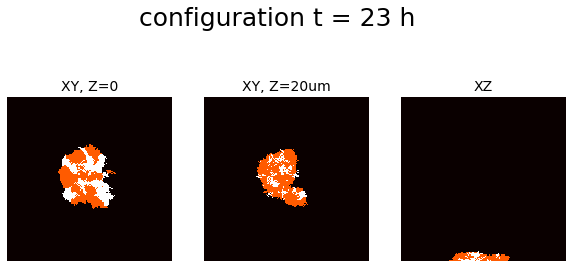

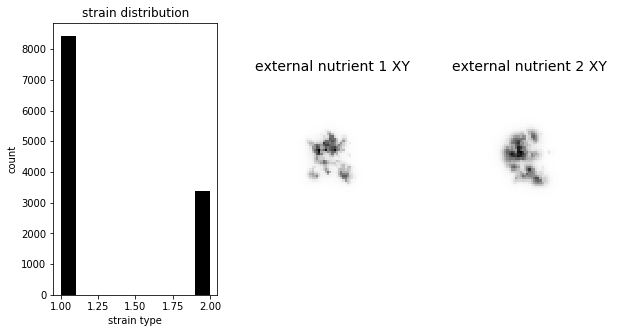

In [484]:
draw_config_conc(X,S,n_nutrients,'configuration t = %s h'%int(tt*dt))